# DS_Synthetic

Diffraction stacking for synthetic data and homogenous medium

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Import modelling
from pyfrac.modelling.kirchhoff import Kirchhoff
# Import diffraction stacking
from pyfrac.locationsolvers.localisationutils import dist2rec
from pyfrac.locationsolvers.imaging import diffraction_stacking
# Import visualization
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d
# Import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *

## Setup
Model, receiver geometry, source

In [2]:
# Velocity Model
nx, ny, nz = 50, 50, 50
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
vel = np.ones([nx,ny,nz])*v0

print(vel.shape)

(50, 50, 50)


In [3]:
# RECEIVERS
dr_xyz = 4*dx

grid_rx_locs = np.arange(dx, (dx*nx)-dx, dr_xyz)
grid_ry_locs = np.arange(dy, (dy*ny)-dy, dr_xyz)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz) 
recs = np.vstack((rx.flatten(), ry.flatten(), rz.flatten()))
nr = recs.shape[1]

In [4]:
recs.shape

(3, 144)

In [5]:
# Microseismic sources
sx, sy, sz = [nx//4, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

Text(0, 0.5, 'y')

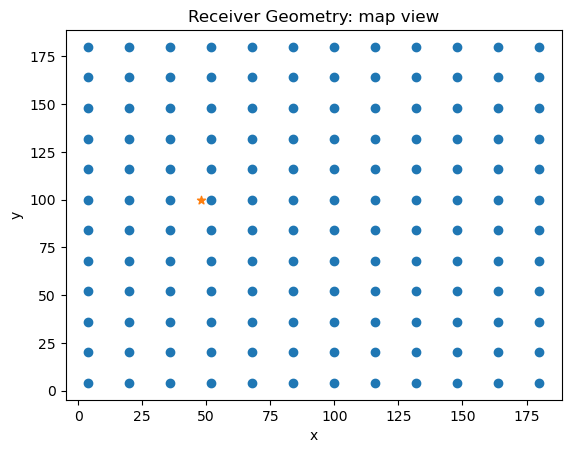

In [6]:
plt.scatter(recs[0],recs[1]);
plt.scatter(sx*dx,sy*dy, marker='*');
plt.title('Receiver Geometry: map view')
plt.xlabel('x')
plt.ylabel('y')

## Generate synthetic data

In [7]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

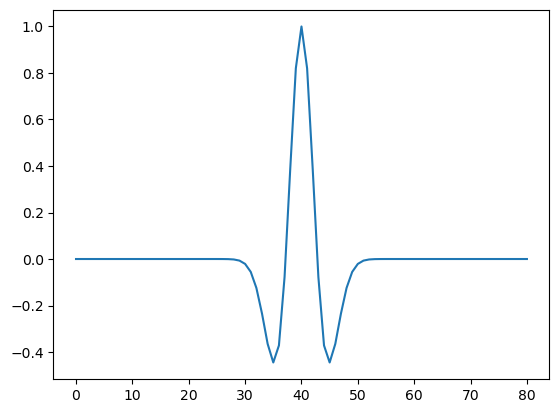

In [8]:
plt.plot(wav);

In [9]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=vel, 
               wav=wav, 
               wavcenter=wavc, 
               mode='eikonal', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

c:\users\anikiev\work\development\kaust\pyfrac\pyfrac\modelling\kirchhoff.py:255: FutureWarning: A new implementation of Kirchhoff is provided in v2.1.0. This currently affects only the inner working of the operator, end-users can continue using the operator in the same way. Nevertheless, it is now recommended to providethe variables trav (and amp) as a tuples containing the traveltime (and amplitude) tables for sources and receivers separately. This behaviour will eventually become default in version v3.0.0.
  warnings.warn(


Dot test passed, v^H(Opu)=-4346.754183774425 - u^H(Op^Hv)=-4346.754183774423


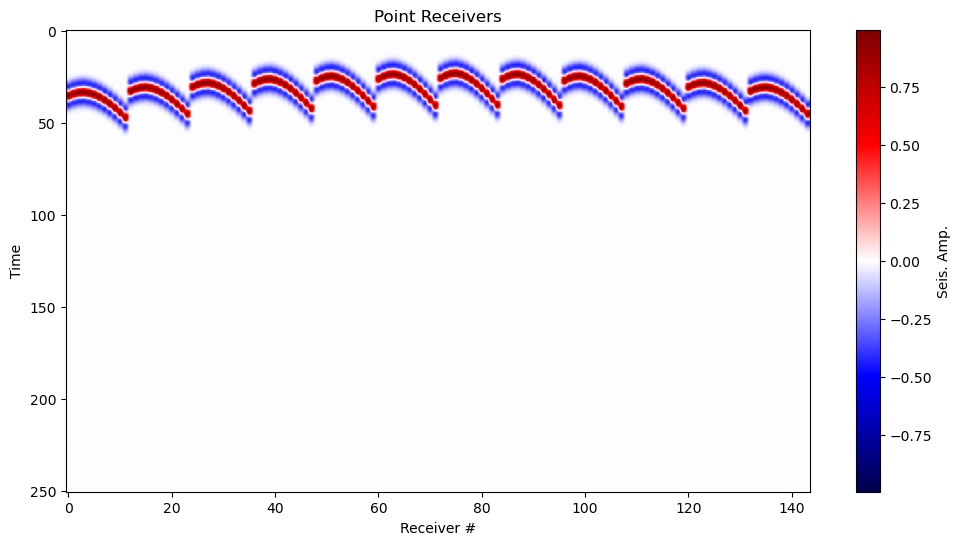

In [10]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
ax = traceimage(frwddata, climQ=99.99);
ax.set_title('Point Receivers');

In [11]:
frwddata.shape

(144, 251)

## Diffraction stacking

In [12]:
# Define search grid
gx = x
gy = y
gz = z

# Prepare traveltimes
#tt = np.zeros([nr,len(gx),len(gy),len(gz)])

tt = 1/v0*dist2rec(recs,gx,gy,gz)
print(tt.shape)

(144, 50, 50, 50)


In [13]:
# Reshape tt into ttg
ttg = tt.reshape(nr, -1)
print(ttg.shape)

(144, 125000)


In [14]:
# Perform standard semblance-based diffraction stack
dstacked, hc = diffraction_stacking(tt=tt,data=frwddata,dt=dt,n_xyz=[len(gx),len(gy),len(gz)],nforhc=10)

c:\users\anikiev\work\development\kaust\pyfrac\pyfrac\visualisation\eventimages.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


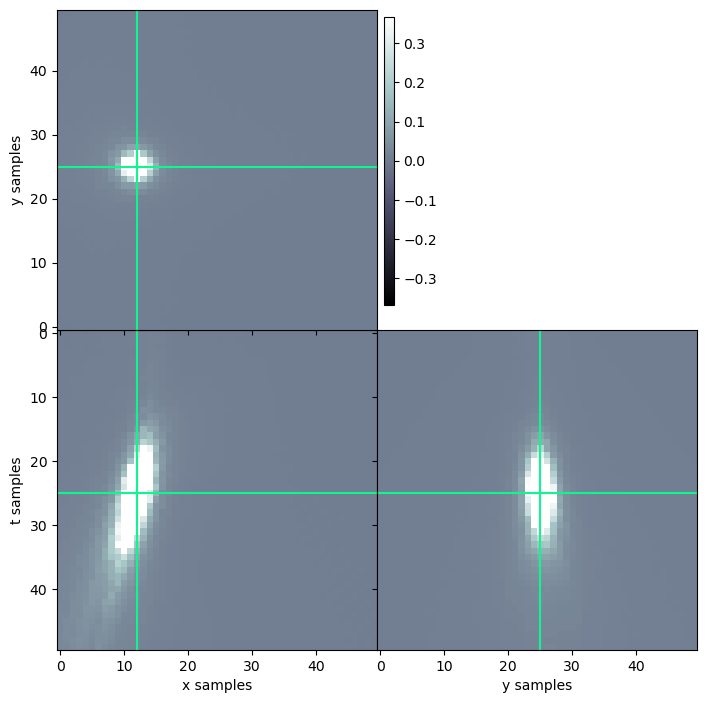

In [15]:
# Visualise image volume
fig,axs = locimage3d(dstacked, x0=sx, y0=sy, z0=sz)